# MLP en **Keras** para Clasificación Multietiqueta
Optimizamos una red neuronal *feed‑forward* (MLP) con **keras/tensorflow** utilizando un *wrapper* de **scikeras** para integrarla en un **pipeline** y ajustar hiperparámetros mediante **Repeated K‑Fold CV**.

Se muestran:
* Gráfica de optimización de λ (regularización L2 = `model__l2`).
* Curva de aprendizaje (F1‑micro).
* Métricas finales F1‑micro y *Hamming loss* en el conjunto de prueba.

## Bloque 1 – Importaciones
Se usa `scikeras` para envolver el modelo Keras y `tensorflow` como backend.

In [41]:
# ----- Bloque 1 -----
import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, hamming_loss, make_scorer

import tensorflow as tf
from tensorflow.keras import layers, regularizers, callbacks, models
from scikeras.wrappers import KerasClassifier

## Bloque 2 – Ruta


In [42]:
# ----- Bloque 2 -----
if os.path.basename(os.getcwd()) != 'Seismic-Multilabel-Event-Classifier':
    os.chdir('..')
    print('CWD ->', os.getcwd())

## Bloque 3 – Carga de datos


In [43]:
# ----- Bloque 3 -----
df = pd.read_json('data/processed/dataset_final.json')
print('Shape:', df.shape)
df.head()

Shape: (1674, 91)


,max_V,rms_V,max_H1,rms_H1,max_H2,rms_H2,duration,zcr_V,dom_freq_V,centroid_V,...,FFT_PCA_62,1 Stiker Slip (SS),2 Normal-Oblique (SO),3 Reverse-Oblique (RO),4-6,6-8,0-200,200-400,400-600,600-
0,0.000342,0.000052,0.000587,0.000111,0.000617,0.000107,321.68,2.014362,0.000000,5.447156,...,0.015319,True,False,False,True,False,False,False,False,True
1,0.003967,0.000347,0.006399,0.000501,0.004988,0.000475,200.00,9.034548,0.781250,17.551070,...,0.015314,True,False,False,True,False,False,False,False,True
2,0.000135,0.000023,0.000204,0.000028,0.000157,0.000026,323.79,1.429895,0.195312,2.573894,...,0.015312,True,False,False,True,False,False,False,False,True
3,0.003166,0.000453,0.005030,0.000657,0.004669,0.000725,41.00,21.189954,14.062500,14.019404,...,0.001835,True,False,False,True,False,False,False,False,True
4,0.000011,0.000002,0.000021,0.000003,0.000018,0.000003,180.80,3.943366,0.195312,10.936094,...,0.015316,True,False,False,True,False,False,False,False,True


## Bloque 4 – Preparación de features y etiquetas


In [44]:
# ----- Bloque 4 -----
label_cols = ['1 Stiker Slip (SS)','2 Normal-Oblique (SO)','3 Reverse-Oblique (RO)',
              '4-6','6-8','0-200','200-400','400-600','600-']
drop_cols = ['Archivo','Falla_lbl','Mag_lbl','Vs_lbl','Combo'] + label_cols
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].values.astype('float32')
y = df[label_cols].astype('float32').values  # multietiqueta 0/1

print('X:', X.shape, 'y:', y.shape)

X: (1674, 82) y: (1674, 9)


## Bloque 5 – Split hold‑out Test


In [45]:
# ----- Bloque 5 -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print('Train:', X_train.shape, ' Test:', X_test.shape)

Train: (1339, 82)  Test: (335, 82)


## Bloque 6 – Función de creación del modelo Keras
Se parametriza tamaño de capa, `dropout` y regularización L2 (`l2`).

In [46]:
# ----- Bloque 6 -----
def make_mlp(hidden_units=(128,), dropout_rate=0.0, l2=1e-4, lr=1e-3):
    tf.keras.backend.clear_session()
    inputs = layers.Input(shape=(X_train.shape[1],))
    x = inputs
    for units in hidden_units:
        x = layers.Dense(units, activation='relu',
                         kernel_regularizer=regularizers.l2(l2))(x)
        if dropout_rate>0:
            x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(y_train.shape[1], activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[])
    return model

## Bloque 7 – Pipeline base


In [47]:
# ----- Bloque 7 -----
base_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KerasClassifier(
        model=make_mlp,
        verbose=0,
        epochs=40,
        batch_size=32,
        hidden_units=(128,),
        dropout_rate=0.0,
        l2=1e-4,
        lr=1e-3,
        callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    ))
])

## Bloque 8 – Búsqueda de hiperparámetros (Repeated K‑Fold)


In [51]:
# ----- Bloque 8 -----
param_grid = {
    'clf__hidden_units': [(128,), (256,), (128,64)],
    'clf__dropout_rate': [0.0, 0.3],
    'clf__l2': [1e-5, 1e-4, 1e-3],
    'clf__lr': [1e-3, 3e-4],
    'clf__batch_size': [32, 64],
    'clf__epochs': [40]
}

rkf = RepeatedKFold(n_splits=2, n_repeats=1, random_state=42)
scorer = make_scorer(f1_score, average='micro')

grid = GridSearchCV(
    base_pipe,
    param_grid=param_grid,
    scoring=scorer,
    cv=rkf,
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train, y_train)

best_params = grid.best_params_
best_lambda = best_params['clf__l2']
print('Mejores hiperparams:', best_params)
print('F1‑micro CV:', grid.best_score_)

/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are:

KeyboardInterrupt: 

## Bloque 9 – Optimización de λ (l2)


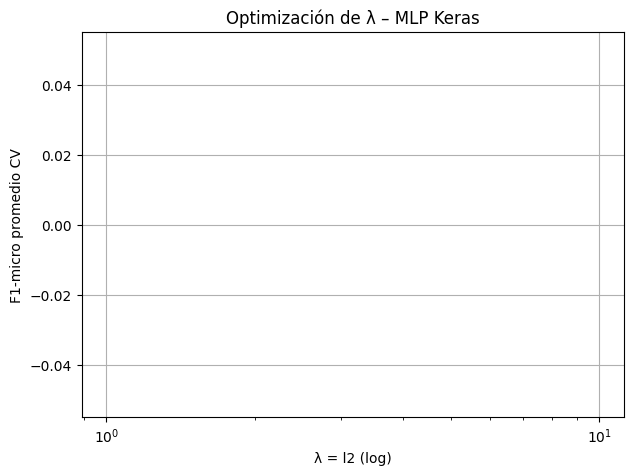

In [ ]:
# ----- Bloque 9 -----
res = pd.DataFrame(grid.cv_results_)
res['lambda'] = res['param_clf__l2'].astype(float)
lambda_scores = res.groupby('lambda')['mean_test_score'].mean().sort_index()

plt.figure(figsize=(7,5))
plt.plot(lambda_scores.index, lambda_scores.values, marker='o')
plt.xscale('log')
plt.xlabel('λ = l2 (log)')
plt.ylabel('F1-micro promedio CV')
plt.title('Optimización de λ – MLP Keras')
plt.grid(True)
plt.show()

## Bloque 10 – Curva de aprendizaje


/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are:

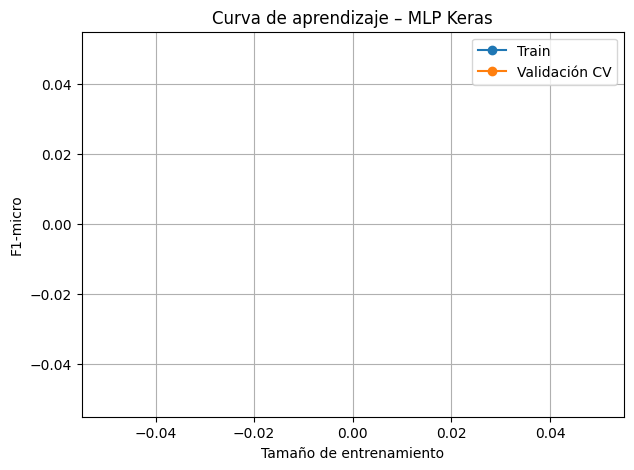

In [ ]:
# ----- Bloque 10 -----
best_model_pipe = grid.best_estimator_

train_sizes, tr_scores, val_scores = learning_curve(
    best_model_pipe, X_train, y_train,
    cv=rkf, scoring=scorer,
    train_sizes=np.linspace(0.1,1.0,6),
    n_jobs=-1
)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, tr_scores.mean(axis=1), 'o-', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validación CV')
plt.xlabel('Tamaño de entrenamiento')
plt.ylabel('F1‑micro')
plt.title('Curva de aprendizaje – MLP Keras')
plt.legend(); plt.grid(True); plt.show()

## Bloque 11 – Evaluación en Test


In [ ]:
# ----- Bloque 11 -----
best_model_pipe.fit(X_train, y_train)
y_pred = best_model_pipe.predict(X_test)
print('Test F1‑micro:', f1_score(y_test, y_pred, average='micro'))
print('Test Hamming loss:', hamming_loss(y_test, y_pred))

/Users/villafuertech/Documents/Academic/University/Sexto_Semestre/Machine_Learning/Seismic-Multilabel-Event-Classifier/env/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

## Bloque 12 – Guardar modelo


In [ ]:
# ----- Bloque 12 -----
os.makedirs('models', exist_ok=True)
joblib.dump(best_model_pipe, 'models/mlp_keras_repkfold.pkl')
print('Modelo guardado en models/mlp_keras_repkfold.pkl')